# Youtube Content Creator Analysis

#### Step 1: Understanding the business problem
I want to create a successful Content Creator in Youtube platform. 
I would like to learn more about what content to create and what are some good practices to be a good Content Creator.

A successful Content Creator would be defined as one that has high number of views.
A good practice would be a common characteristic that is found across the successful channels. 


#### Step 2: Get Data

In [230]:
# Import required packages
from googleapiclient.discovery import build
import pandas as pd
import seaborn as sns
import config

In [195]:
# Prepare Youtube API
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=config.api_key)

In [196]:
# Choose 5 current popular channels to analyse (via Channel ID)
channel_ids = ['UC2UXDak6o7rBm23k3Vv5dww', # Tina Huang
             'UC7cs8q-gJRlGwj4A8OmCmXg', # Alex the Analyst
             'UCLLw7jmFsvfIVaUFsLs8mlQ', # Luke Barousse
             'UCiT9RITQ9PW6BhXK0y2jaeg', # Ken Jee
             'UCnz-ZXXER4jOvuED5trXfEA' # techTFQ
            ]

In [197]:
# Function to get channel statistics
def get_channel_stats(youtube, channel_ids):
    
    # Prepare Youtube request
    request = youtube.channels().list(
                part ='snippet,contentDetails,statistics',
                id = ','.join(channel_ids) # to change list to string seoarated by ','
                )
    
    # Execute Youtube request and store response
    response = request.execute()

    # Store response in a list
    all_data = []
    for i in range(len(response['items'])):
        data = dict(Channel_name = response['items'][i]['snippet']['title'],
                    Subscribers = response['items'][i]['statistics']['subscriberCount'],
                    Views = response['items'][i]['statistics']['viewCount'],
                    Total_videos = response['items'][i]['statistics']['videoCount'],
                    playlist_id = response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
                )
        
        all_data.append(data)

    return all_data

In [198]:
# Run Function and store raw data
channel_statistics = get_channel_stats(youtube, channel_ids)

In [199]:
# convert list to dataframe
channel_data = pd.DataFrame(channel_statistics)

In [200]:
# Preview data
channel_data

,Channel_name,Subscribers,Views,Total_videos,playlist_id
0,Alex The Analyst,497000,19772721,216,UU7cs8q-gJRlGwj4A8OmCmXg
1,Luke Barousse,353000,16151815,135,UULLw7jmFsvfIVaUFsLs8mlQ
2,Ken Jee,245000,8154487,276,UUiT9RITQ9PW6BhXK0y2jaeg
3,techTFQ,207000,10207520,89,UUnz-ZXXER4jOvuED5trXfEA
4,Tina Huang,548000,23796879,125,UU2UXDak6o7rBm23k3Vv5dww


In [201]:
# Testing purpose only
channel_data.to_csv('RawChannelData.csv')

In [202]:
# Check Data Types before conversion
channel_data.dtypes

Channel_name    object
Subscribers     object
Views           object
Total_videos    object
playlist_id     object
dtype: object

In [203]:
# Convert Data Types (to numeric)
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])


Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
playlist_id     object
dtype: object

In [ ]:
# Check Data Types after conversion
channel_data.dtypes

In [204]:
# Export for PowerBI
channel_data.to_csv('ChannelData.csv')

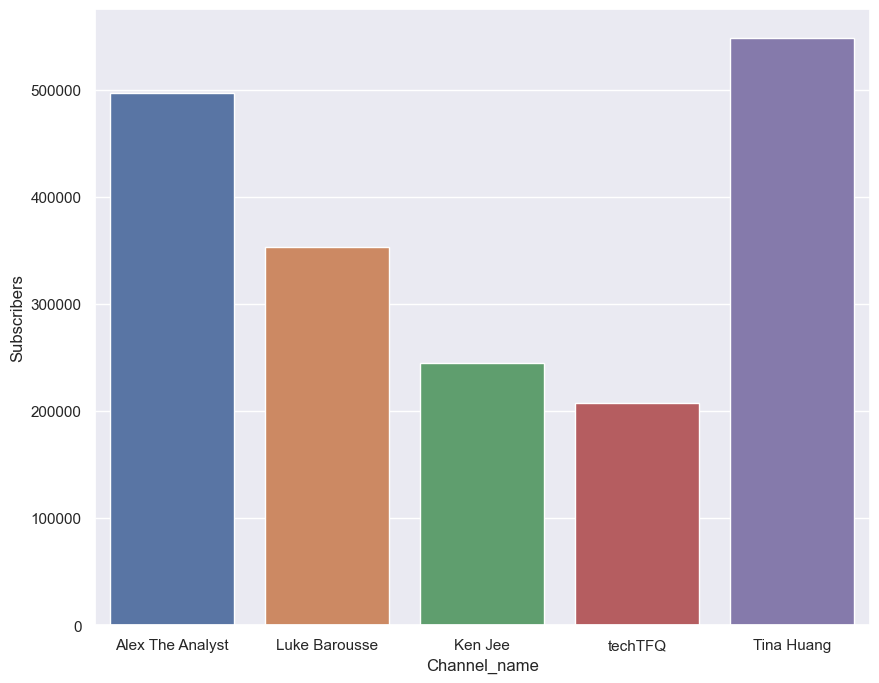

In [205]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='Channel_name',y='Subscribers',data=channel_data)

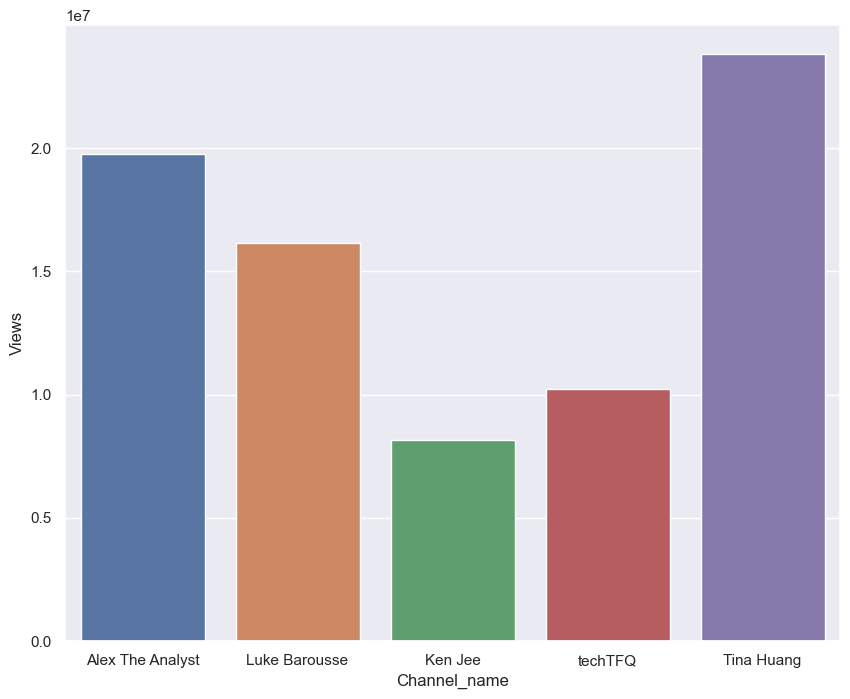

In [206]:
ax = sns.barplot(x='Channel_name',y='Views',data=channel_data)

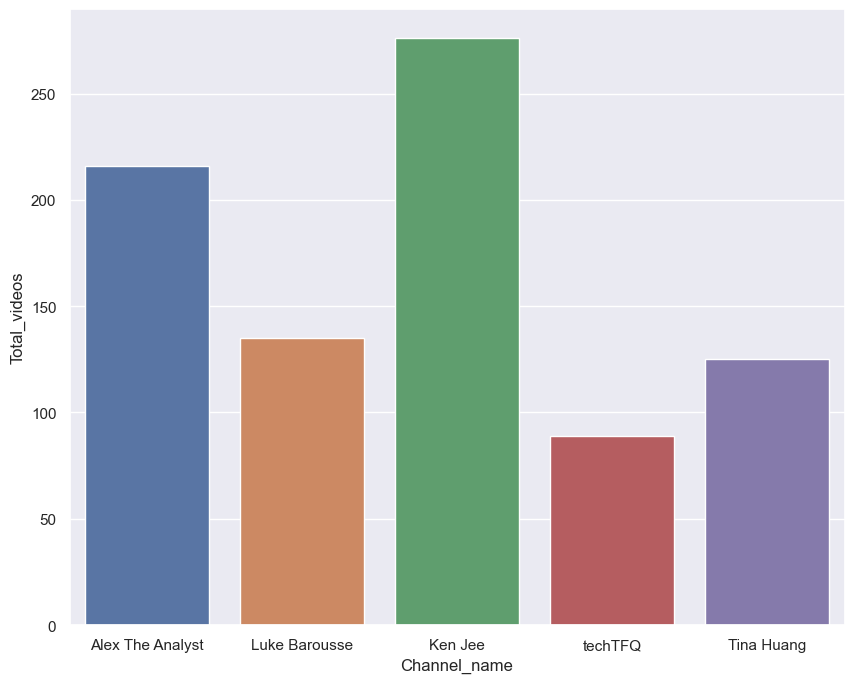

In [207]:
ax = sns.barplot(x='Channel_name',y='Total_videos',data=channel_data)

##  Function to get video ids

In [208]:
playlist_id = channel_data.loc[channel_data['Channel_name']=='Ken Jee', 'playlist_id'].iloc[0]

In [209]:
def get_video_ids(youtube, playlist_id):

    #prepare request from youtube api
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50
                )
    
    #execute request and store as response
    response = request.execute()

    #store video ids in list
    video_ids = []
    for i in range (len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])

    #check for next page
    print("nextPageToken(first part) = "+response.get('nextPageToken'))
    next_page_token = response.get('nextPageToken')
    more_pages = True
    while more_pages:
        #if no more pages, update more_pages variable to False
        if next_page_token is None:
            more_pages = False
        #if there are more pages, run the request with pageToken and append video_ids
        else:
            #run new request with page Token
            request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50,
                pageToken = next_page_token
                )
            
            #execute new request
            response = request.execute()

            #loop through new video ids
            for i in range (len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            #update next_page_token for next round of while loop
            print("nextPageToken second part= "+str(response.get('nextPageToken')))
            next_page_token = response.get('nextPageToken')
            # print(next_page_token)


    return video_ids

In [210]:
video_ids = get_video_ids(youtube, playlist_id)

nextPageToken(first part) = EAAaBlBUOkNESQ
nextPageToken second part= EAAaBlBUOkNHUQ
nextPageToken second part= EAAaB1BUOkNKWUI
nextPageToken second part= EAAaB1BUOkNNZ0I
nextPageToken second part= EAAaB1BUOkNQb0I
nextPageToken second part= None


In [211]:
video_ids

['HVpbmu7rFYE',
 'NQQ3DRdXAXE',
 'xpi-M2j3NmE',
 'X07w7QFoLpc',
 'RRnThAtKuq0',
 'r3zOpjEOkgE',
 's-XYFEzy9Wc',
 'iBh1wl4o6V4',
 'L6lXKdP4Qbg',
 'xGDl6rlBygU',
 'SY6y6Y8C594',
 '1RUj2aLQx8I',
 'MkzZXSw1Glk',
 '9neDFXTxKxA',
 'UaNNVukM27g',
 '3lN0-S3symM',
 'M-AN8eWLxms',
 'MXFZhbvQqM8',
 '54n61XjKifI',
 'pyWYIRR8rrE',
 'onwRfbt--cw',
 'u6P23ouSYhA',
 'RMMVuvS7S_g',
 '5AwbPAV8FS0',
 'A2OQgU0IRNo',
 'x5Q_nrIqFik',
 '7ja2ELBVMlU',
 'Z2MyLQa_vVw',
 'JTlB9fwYRk0',
 'OJDf_fTENJ4',
 'nqCkdqhV-JY',
 'b8t8lDL13sg',
 't6CD1EwU5kc',
 'eIxHe45hzhQ',
 '3NJOWWvNK3I',
 '4_VtMWJSo1o',
 'OybXWl3IWvI',
 'nRHPQ5ZeB5Y',
 '0JWC4M0Qhqc',
 'oNvyvYGw5n4',
 'GaZRuchRCyw',
 'EBjYqC3aNTA',
 'QMP858aZcow',
 '0ItYIoOrrUs',
 'KzTFoUbThvM',
 'bBJd0oPdNak',
 'Yk-unX4KnV4',
 'z0_xrtFdFj8',
 'vVpkXEIn-q0',
 'aipz4p7GDL4',
 'iPdO9MwdcLE',
 'YPph59-rTxA',
 '-2U2CMYom00',
 'KEeUR8UDy-s',
 '0jTtHYie3CU',
 '2RWwN5ZT4tA',
 'rEWPqw6rMGI',
 'o-wsyxWbPOw',
 'xpIFS6jZbe8',
 '-zbLpoJVBMI',
 'scSc6YSanQ0',
 'FqNpDNmpcEo',
 'vwvdtX

Function to get video details

In [212]:
def get_video_details(youtube, video_ids):

    all_video_stats=[]

    for i in range (0, len(video_ids), 50):
        request = youtube.videos().list(
                    part='snippet,statistics',
                    id=','.join(video_ids[i:i+50]) #note that youtube limitation is max 50 
                    )
        
        response = request.execute()

        for video in response['items']:
            video_stats=dict(Title = video['snippet']['title'],
                             Published_date = video['snippet']['publishedAt'],
                             Views = video['statistics']['viewCount'],
                             Likes = video['statistics']['likeCount'],
                            #  Dislikes = video['statistics']['dislikeCount'], #no more dislikeCount
                             Comments = video['statistics']['commentCount']
                             )
            all_video_stats.append(video_stats)



    return all_video_stats

In [213]:
#execute and store data in variable
video_details = get_video_details(youtube, video_ids)

In [214]:
# use pandas to create dataframe
video_data = pd.DataFrame(video_details)

In [215]:
video_data

,Title,Published_date,Views,Likes,Comments
0,AI: A Customer Service Revolution?,2023-05-26T12:00:21Z,2547,89,24
1,Beginner Kaggle Data Science Project Walk-Thro...,2023-05-16T12:00:25Z,11186,487,51
2,How I Would Learn Data Science with AI (If I C...,2023-05-04T12:04:56Z,20756,918,60
3,This AI question will determine our future,2023-04-06T13:00:32Z,3947,253,37
4,I'll Never Code the Same Again... (GPT-4 is OP),2023-04-03T13:00:27Z,69244,781,77
...,...,...,...,...,...
271,How to Simulate NBA Games in Python,2018-11-19T23:31:49Z,17422,387,54
272,Should You Get A Masters in Data Science?,2018-11-14T01:39:33Z,20457,304,138
273,How I Became A Data Scientist From a Business ...,2018-11-12T00:26:08Z,6376,198,23
274,Predicting Season Long NBA Wins Using Multiple...,2018-07-10T16:39:52Z,8529,193,17


In [216]:
#Check dataframe data type
video_data.dtypes

Title             object
Published_date    object
Views             object
Likes             object
Comments          object
dtype: object

In [217]:
#modify datetime
video_data['Published_date'] = pd.to_datetime(video_data['Published_date']).dt.date
video_data['Views'] = pd.to_numeric(video_data['Views'])
video_data['Likes'] = pd.to_numeric(video_data['Likes'])


In [218]:
#Check dataframe data type
video_data.dtypes

Title             object
Published_date    object
Views              int64
Likes              int64
Comments          object
dtype: object

In [219]:
#top 10 videos
top10_videos = video_data.sort_values(by='Views', ascending = False).head(10)
top10_videos

,Title,Published_date,Views,Likes,Comments
178,How I Would Learn Data Science (If I Had to St...,2020-05-08,1388744,48987,1997
199,The Best Free Data Science Courses Nobody is T...,2020-03-09,341296,21034,618
58,How I Would Learn Data Science in 2022 (If I H...,2021-12-27,334409,14789,536
205,3 Proven Data Science Projects for Beginners (...,2020-02-17,320077,17576,519
154,Beginner Kaggle Data Science Project Walk-Thro...,2020-07-17,306809,6912,410
191,Data Science Project from Scratch - Part 1 (Pr...,2020-04-03,173201,4587,170
244,The Projects You Should Do To Get A Data Scien...,2019-07-30,148436,5672,253
91,Why You Probably Won't Become a Data Scientist,2021-04-09,136104,3995,480
106,How I Would Learn Data Science in 2021 (What H...,2020-12-19,131119,5973,488
175,How to Make A Data Science Portfolio Website w...,2020-05-15,120698,4198,192


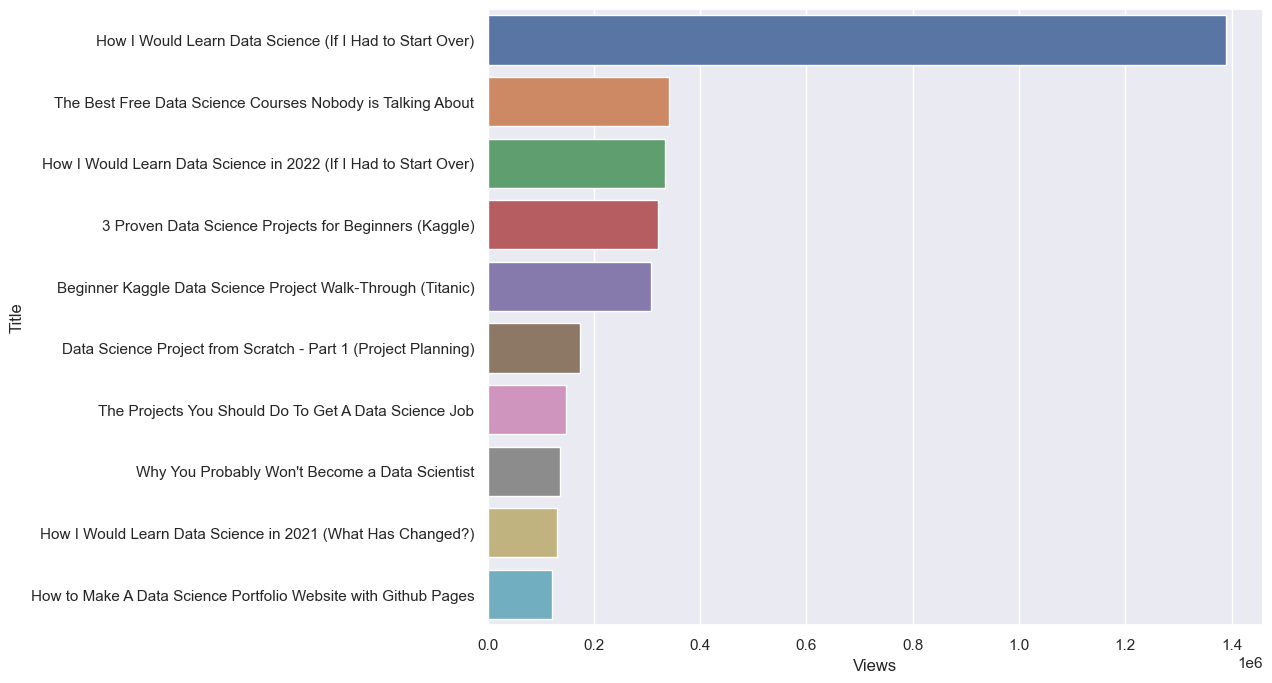

In [220]:
ax1 = sns.barplot(x='Views',y='Title',data=top10_videos)

In [221]:
video_data

,Title,Published_date,Views,Likes,Comments
0,AI: A Customer Service Revolution?,2023-05-26,2547,89,24
1,Beginner Kaggle Data Science Project Walk-Thro...,2023-05-16,11186,487,51
2,How I Would Learn Data Science with AI (If I C...,2023-05-04,20756,918,60
3,This AI question will determine our future,2023-04-06,3947,253,37
4,I'll Never Code the Same Again... (GPT-4 is OP),2023-04-03,69244,781,77
...,...,...,...,...,...
271,How to Simulate NBA Games in Python,2018-11-19,17422,387,54
272,Should You Get A Masters in Data Science?,2018-11-14,20457,304,138
273,How I Became A Data Scientist From a Business ...,2018-11-12,6376,198,23
274,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,8529,193,17


In [222]:
video_data['Month'] = pd.to_datetime(video_data['Published_date']).dt.strftime('%b')

In [223]:
video_data

,Title,Published_date,Views,Likes,Comments,Month
0,AI: A Customer Service Revolution?,2023-05-26,2547,89,24,May
1,Beginner Kaggle Data Science Project Walk-Thro...,2023-05-16,11186,487,51,May
2,How I Would Learn Data Science with AI (If I C...,2023-05-04,20756,918,60,May
3,This AI question will determine our future,2023-04-06,3947,253,37,Apr
4,I'll Never Code the Same Again... (GPT-4 is OP),2023-04-03,69244,781,77,Apr
...,...,...,...,...,...,...
271,How to Simulate NBA Games in Python,2018-11-19,17422,387,54,Nov
272,Should You Get A Masters in Data Science?,2018-11-14,20457,304,138,Nov
273,How I Became A Data Scientist From a Business ...,2018-11-12,6376,198,23,Nov
274,Predicting Season Long NBA Wins Using Multiple...,2018-07-10,8529,193,17,Jul


In [224]:
videos_per_month = video_data.groupby('Month', as_index=False).size()
videos_per_month

,Month,size
0,Apr,22
1,Aug,24
2,Dec,20
3,Feb,25
4,Jan,29
5,Jul,25
6,Jun,19
7,Mar,32
8,May,24
9,Nov,20


In [225]:
sort_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [226]:
videos_per_month.index = pd.CategoricalIndex(videos_per_month['Month'], categories=sort_order, ordered=True)

In [227]:
videos_per_month = videos_per_month.sort_index()

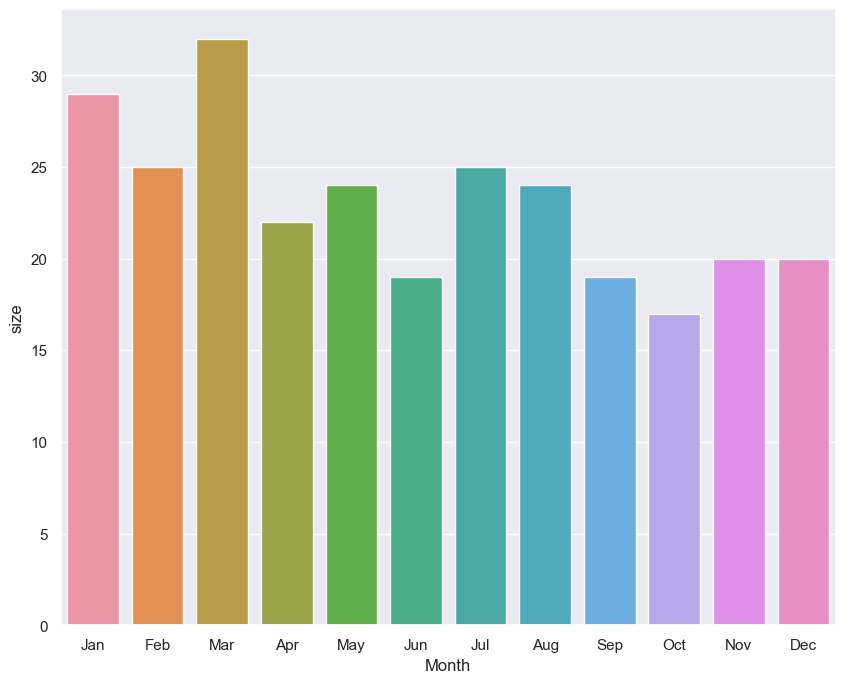

In [228]:
ax2 = sns.barplot(x='Month',y='size',data=videos_per_month)

In [229]:
video_data.to_csv('Video_Details(Ken Jee).csv')